<a href="https://colab.research.google.com/github/kolikaran1992/Neural-Networks/blob/main/Positional_Encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

SEED = 49

import matplotlib.pyplot as plt
plt.rcParams.update({'axes.titlesize': 20, 
                     'axes.labelsize': 15,
                     'xtick.labelsize':10,
                     'ytick.labelsize':10
                     })

$$PE(p, 2i) = sin(\frac{p}{10000^{\frac{2i}{d}}})$$

$$PE(p, 2i+1) = cos(\frac{p}{10000^{\frac{2i}{d}}})$$

Where $d$ is the dimension of the input vectors

In [15]:
def get_angles(pos, i, d):
    """
    pos.shape == (max_pos_enc,1)
    i.shape = (1, d)
    d is an int
    """
    ## (i//2) == array like [[0,0, 1,1, ..., n,n]]
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d))
    ## (max_pos_enc, 1)*(1, d) = (max_pos_enc, d)
    return pos * angle_rates

In [16]:
get_angles(np.arange(pos)[:, np.newaxis], 
           np.arange(d)[np.newaxis, :], 
           d)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 2.51188643e-02, 2.51188643e-02,
        6.30957344e-04],
       [2.00000000e+00, 2.00000000e+00, 5.02377286e-02, 5.02377286e-02,
        1.26191469e-03],
       [3.00000000e+00, 3.00000000e+00, 7.53565929e-02, 7.53565929e-02,
        1.89287203e-03],
       [4.00000000e+00, 4.00000000e+00, 1.00475457e-01, 1.00475457e-01,
        2.52382938e-03],
       [5.00000000e+00, 5.00000000e+00, 1.25594322e-01, 1.25594322e-01,
        3.15478672e-03],
       [6.00000000e+00, 6.00000000e+00, 1.50713186e-01, 1.50713186e-01,
        3.78574407e-03],
       [7.00000000e+00, 7.00000000e+00, 1.75832050e-01, 1.75832050e-01,
        4.41670141e-03],
       [8.00000000e+00, 8.00000000e+00, 2.00950915e-01, 2.00950915e-01,
        5.04765876e-03],
       [9.00000000e+00, 9.00000000e+00, 2.26069779e-01, 2.26069779e-01,
        5.67861610e-03]])

In [17]:
def positional_encoding(pos, d):
    angle_rads = get_angles(np.arange(pos)[:, np.newaxis],
                            np.arange(d)[np.newaxis, :],
                            d)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return pos_encoding.astype(np.float32)

In [30]:
pos = 10
d = 6
pos_enc = positional_encoding(pos, d)
pos_enc.shape

(1, 10, 6)

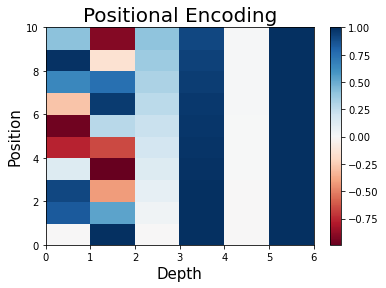

sin and cosine are applied along depth at alternate positions


In [31]:
plt.title('Positional Encoding')
plt.pcolormesh(pos_enc[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d))
plt.ylabel('Position')
plt.colorbar()
plt.show()
print('sin and cosine are applied along depth at alternate positions')

Each row in the above plot is a positional encoding

Using $\text{sin}$ and $\text{cos}$ in the positional encoding helps the model to attend to relative position. This is because $PE(p+k)$ is a linear combination of $PE(p)$ and $PE(k)$

Let $10000^{\frac{1}{d}}$ be n

$$PE(p, 2i) = sin(\frac{p}{n^{2i}})$$

$$PE(p, 2i+1) = cos(\frac{p}{n^{2i}})$$

$$PE(p+k, 2i) = sin(\frac{p+k}{n^{2i}})=sin(\frac{p}{n^{2i}})cos(\frac{k}{n^{2i}})+sin(\frac{k}{n^{2i}})cos(\frac{p}{n^{2i}})$$

$$PE(p+k, 2i+1) = sin(\frac{p+k}{n^{2i}})=cos(\frac{p}{n^{2i}})cos(\frac{k}{n^{2i}})-sin(\frac{p}{n^{2i}})sin(\frac{k}{n^{2i}})$$

$$\begin{bmatrix} PE(p+k, 2i) \\ PE(p+k, 2i+1)\end{bmatrix}=\begin{bmatrix} cos(\frac{k}{n^{2i}}) \quad sin(\frac{k}{n^{2i}}) \\ -sin(\frac{k}{n^{2i}}) \quad cos(\frac{k}{n^{2i}}) \end{bmatrix}\begin{bmatrix} PE(p, 2i) \\ PE(p, 2i+1)\end{bmatrix}$$

$$PE(p) = \begin{bmatrix} PE(p, 0) \\ PE(p, 1) \\ \vdots \\ PE(p, 2i) \\ PE(p, 2i+1) \\ \vdots \\ PE(p, 2n) \\ PE(p, 2n+1)\end{bmatrix}$$

Where, $2n+1=d$

$$PE(p+k) = \begin{bmatrix} M_1 \quad 0 \quad 0 \quad \dots \quad 0 \\ 0 \quad M_2 \quad 0 \quad \dots \quad 0 \\ 0 \quad 0 \quad M_3 \quad \dots \quad 0 \\ \vdots \\ \quad 0 \quad 0 \quad \  \ 0 \quad \dots \quad M_{d//2}\end{bmatrix} PE(p)$$

Where, $M_i = \begin{bmatrix} cos(\frac{k}{n^{2i}}) \quad sin(\frac{k}{n^{2i}}) \\ -sin(\frac{k}{n^{2i}}) \quad cos(\frac{k}{n^{2i}}) \end{bmatrix}$

Thereofore, $PE(p+k)$ is a linear function of $PE(p)$, furthermore, the linear transformation does not depend on $p$